beta493_mediana: -5.678297516262285


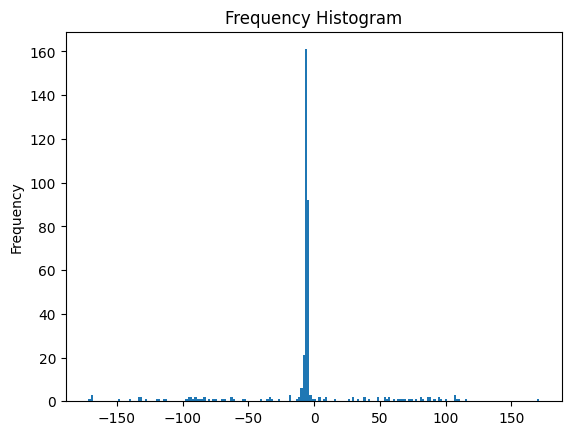

In [1]:
import os
import cv2
import math
import statistics
import matplotlib.pyplot as plt

PHOTO_PATH = "sobrevuelo_pamplona/originales"
PHOTO_START = 493
PHOTO_END = 494

def calculate_features(image_1_cv, image_2_cv, feature_number):
    orb = cv2.ORB_create(nfeatures = feature_number)
    keypoints_1, descriptors_1 = orb.detectAndCompute(image_1_cv, None)
    keypoints_2, descriptors_2 = orb.detectAndCompute(image_2_cv, None)
    return keypoints_1, keypoints_2, descriptors_1, descriptors_2

def calculate_matches(descriptors_1, descriptors_2):
    brute_force = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = brute_force.match(descriptors_1, descriptors_2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

def display_matches(image_1_cv, keypoints_1, image_2_cv, keypoints_2, matches):
    match_img = cv2.drawMatches(image_1_cv, keypoints_1, image_2_cv, keypoints_2, matches[:10], None)
    resize = cv2.resize(match_img, (1600,600), interpolation = cv2.INTER_AREA)
    cv2.imshow('matches', resize)
    cv2.waitKey(0)
    cv2.destroyWindow('matches')

def find_matching_coordinates(keypoints_1, keypoints_2, matches):
    coordinates_1 = []
    coordinates_2 = []
    for match in matches:
        image_1_idx = match.queryIdx
        image_2_idx = match.trainIdx
        (x1,y1) = keypoints_1[image_1_idx].pt
        (x2,y2) = keypoints_2[image_2_idx].pt
        coordinates_1.append((x1,y1))
        coordinates_2.append((x2,y2))
    return coordinates_1, coordinates_2

path = os.path.dirname(os.path.realpath("__file__"))
photo_path = os.path.join(path, PHOTO_PATH)
for i in range(PHOTO_START, PHOTO_END):
    photo_a = os.path.join(photo_path, "atlantes_%d.jpg" % (i))
    photo_b = os.path.join(photo_path, "atlantes_%d.jpg" % (i+1))
    photo_a_cv = cv2.imread(photo_a, 0)
    photo_b_cv = cv2.imread(photo_b, 0)
    keypoints_a, keypoints_b, descriptors_a, descriptors_b = calculate_features(photo_a_cv, photo_b_cv, 1000)
    matches = calculate_matches(descriptors_a, descriptors_b)
    coordinates_a, coordinates_b = find_matching_coordinates(keypoints_a, keypoints_b, matches)
    beta_list = list()
    for ca, cb in zip(coordinates_a, coordinates_b):
        dx = round(cb[0] - ca[0])
        dy = round(cb[1] - ca[1])
        beta_rad = math.atan2(-dy, dx)
        beta_deg = math.degrees(beta_rad)
        beta_list.append(beta_deg)
        #print(f"H: {dx}; V: {dy}; β: {beta_deg}")
    # https://www.mathsisfun.com/data/frequency-grouped-mean-median-mode.html
    print(f"beta{i}_mediana: {statistics.median(beta_list)}")

    # https://mlstudio.jaol.net/matplotlib-histograma-python-ejemplos/
    plt.hist(beta_list, bins=200)
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency')

In [21]:
# Rotar foto 493 152,78º
from PIL import Image

PHOTO_ID = 493
PHOTO_ANGLE = 152.78
PHOTO_ORG_PATH = "sobrevuelo_pamplona/originales"
PHOTO_ROT_PATH = "sobrevuelo_pamplona/girada_por_codigo"
path = os.path.dirname(os.path.realpath("__file__"))

photo_org_path = os.path.join(path, PHOTO_ORG_PATH)
photo_org = os.path.join(photo_org_path, "atlantes_%d.jpg" % (PHOTO_ID))
photo_rot_path = os.path.join(path, PHOTO_ROT_PATH)
photo_rot = os.path.join(photo_rot_path, "atlantes_%d.jpg" % (PHOTO_ID))

with Image.open(photo_org, 'r') as photo_org_img:
    photo_org_w, photo_org_h = photo_org_img.size

!convert {photo_org} -rotate {-PHOTO_ANGLE} -gravity Center {photo_rot}

with Image.open(photo_rot, 'r') as photo_rot_img:
    photo_rot_w, photo_rot_h = photo_rot_img.size

print(photo_org_w)
print(photo_org_h)
print(photo_rot_w)
print(photo_rot_h)

x = (photo_rot_w - photo_org_w) / 2
y = (photo_rot_h - photo_org_h) / 2

!convert {photo_rot} -crop {photo_org_w}x{photo_org_h}+{x}+{y} -gravity Center {photo_rot}

3280
2464
4046
3694


`convert ${i} -crop wxh+x+y -resize wsxhs -gravity Center ${new}`

donde:

* w: ancho del crop
* h: alto del crop
* x: posición horizontal esquina superior derecha del crop
* y: posición vertical esquina superior derecha del crop
* ws: ancho del reescalado final
* hs: alto del reescalado final

In [27]:
# Rotación imágenes con OpenCV
# https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point
import numpy as np
import cv2

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

PHOTO_ID = 493
PHOTO_ANGLE = 152.78
PHOTO_ORG_PATH = "sobrevuelo_pamplona/originales"
PHOTO_ROT_PATH = "sobrevuelo_pamplona/girada_por_codigo2"
path = os.path.dirname(os.path.realpath("__file__"))

photo_org_path = os.path.join(path, PHOTO_ORG_PATH)
photo_org = os.path.join(photo_org_path, "atlantes_%d.jpg" % (PHOTO_ID))
photo_rot_path = os.path.join(path, PHOTO_ROT_PATH)
photo_rot = os.path.join(photo_rot_path, "atlantes_%d.jpg" % (PHOTO_ID))

photo_org_cv = cv2.imread(photo_org, cv2.IMREAD_UNCHANGED)
photo_rot_cv = rotate_image(photo_org_cv, PHOTO_ANGLE)
cv2.imwrite(photo_rot, photo_rot_cv)

True

In [3]:
# Función conversión coordenada en formato DMS (grados, minutos, segundos) a decimal
def dms2dec(dms, ref):
    return (dms[0] + dms[1] / 60. + dms[2] / 3600.) * (1 if ref in ('N', 'E') else -1)

lat_a = (43.0, 5.0, 51.4)
lat_a_ref = 'N'
lat_b = (2.0, 23.0, 41.8)
lat_b_ref = 'W'

print(dms2dec(lat_b, lat_b_ref))

#    pnt_493 = (43.097612303689, -2.3949488058073)
#    pnt_494 = (42.5769655132425, -1.34409030873256)
#    pnt_X = (43.097612303689, -1.34409030873256)


-2.3949444444444445


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


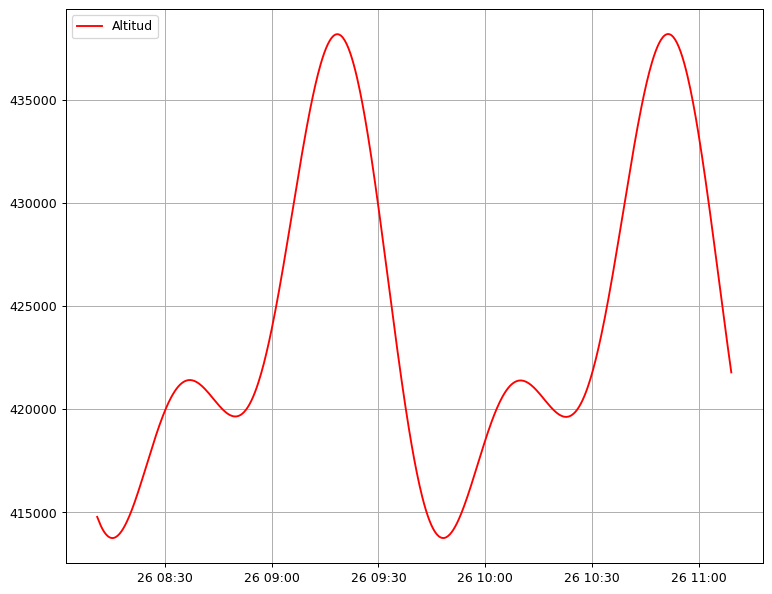

In [4]:
# Gráfico de altitud
%pylab inline
import os
import pandas

# Adjusting chart dimensions    
plt.rcParams["figure.figsize"] = (10, 8)                  # Size of charts in inches
plt.rcParams["figure.dpi"] = 90                           # Resolution of charts in DPIs

# Defining some environment variables for data sources
path = os.path.dirname(os.path.realpath("__file__"))
RESULTS_FILE = "atlantes_2021-2022.csv"     

file = os.path.join(path, RESULTS_FILE)    # CSV input file complete path

data = pandas.read_csv(file, parse_dates=[0])       # Reading whole file

# Columns in file:
#    "datetime", "picture_file", "latitude", "longitude", "elevation", "temp_cpu", "temp_h", "temp_p",
#    "humidity", "pressure", "pitch", "roll", "yaw", "mag_x", "mag_y", "mag_z",
#    "accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"
data_x = data.datetime
data_y1 = data.elevation


fig, ax = plt.subplots()
ax.plot(data_x, data_y1, label="Altitud", color="red")

plt.legend()                                  # Activating chart legend
plt.grid()                                    # Activating chart grid
plt.show()                                    # Showing the chart

In [5]:
# Península de la Magdalena: 43.469456, -3.768367
# Balsa de Ezkoriz: 42.778379, -1.575647
# 1105x512

# https://www.cosmoscalibur.com/blog/calcular-distancia-geodesica-con-python/
import geopy.distance

pnt_493 = (43.469456, -3.768367)
pnt_494 = (42.778379, -1.575647)
pnt_X = (43.469456, -1.575647)

print(geopy.distance.great_circle(pnt_493, pnt_494))
print(geopy.distance.great_circle(pnt_493, pnt_X))
print(geopy.distance.great_circle(pnt_X, pnt_494))

193.8325041492589 km
176.94488493682684 km
76.8443648748625 km


* 1105px equivalen a 176945m
* 512px  equivalen a 76844m

GSD (m/pixel): 161.38456

* 1105px = 178330m
* 512px  = 82629m

Foto: 445; alpha: 20.513879965716082; gamma: 206.40375773064346
Foto: 446; alpha: 19.41345026509236; gamma: 205.30332803001974
Foto: 447; alpha: 18.294524243199554; gamma: 204.18440200812694
Foto: 448; alpha: 17.15850726515467; gamma: 203.04838503008204
Foto: 449; alpha: 16.003139921678297; gamma: 201.89301768660567
Foto: 450; alpha: 14.834328663657553; gamma: 200.72420642858492
Foto: 451; alpha: 13.647427236252012; gamma: 199.5373050011794
Foto: 452; alpha: 12.447208908255812; gamma: 198.3370866731832
Foto: 453; alpha: 11.23342849903942; gamma: 197.1233062639668
Foto: 454; alpha: 10.00553882625628; gamma: 195.89541659118368
Foto: 455; alpha: 8.768888413853645; gamma: 194.65876617878104
Foto: 456; alpha: 7.520241494402383; gamma: 193.41011925932978
Foto: 457; alpha: 6.261830192501049; gamma: 192.15170795742844
Foto: 458; alpha: 4.9988872439592384; gamma: 190.88876500888662
Foto: 459; alpha: 3.7258096384119677; gamma: 189.61568740333934
Foto: 460; alpha: 2.4508813821963087; gamma: 188.3

Foto: 575; alpha: -52.9437050129708; gamma: 132.94617275195657
Foto: 576; alpha: -52.745646460849485; gamma: 133.1442313040779
Foto: 577; alpha: -52.538464338328964; gamma: 133.3514134265984
Foto: 578; alpha: -52.32405632398258; gamma: 133.5658214409448
Foto: 579; alpha: -52.095490641768016; gamma: 133.79438712315937
Foto: 580; alpha: -51.857285107133535; gamma: 134.03259265779386
Foto: 581; alpha: -51.60867959309459; gamma: 134.28119817183278
Foto: 582; alpha: -51.348704042985354; gamma: 134.54117372194202
Foto: 583; alpha: -51.07901116858226; gamma: 134.81086659634514
Foto: 584; alpha: -50.7964331274641; gamma: 135.09344463746328
Foto: 585; alpha: -50.50201539732251; gamma: 135.38786236760487
Foto: 586; alpha: -50.19496251602297; gamma: 135.6949152489044
Foto: 587; alpha: -49.879707297920376; gamma: 136.01017046700701
Foto: 588; alpha: -49.54908343133831; gamma: 136.3407943335891
Foto: 589; alpha: -49.207947792845765; gamma: 136.6819299720816
Foto: 590; alpha: -48.85314919113106; gam

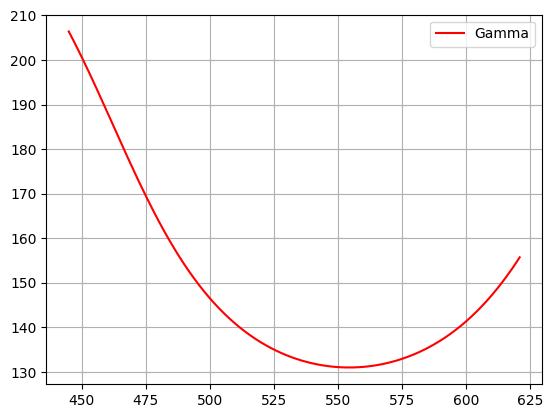

In [6]:
# Ángulo de rotación de cada foto
import os
import cv2
import numpy as np
import math
import exif
from geopy import distance


def dms2dec(dms, ref):
    return (dms[0] + dms[1] / 60. + dms[2] / 3600.) * (1 if ref in ('N', 'E') else -1)

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

PHOTO_ORG_PATH = "atlantes_2021-2022"
PHOTO_ROT_PATH = "atlantes_2021-2022_rotadas"
PHOTO_START = 445
PHOTO_END = 622
BETA = -5.889877764927383
path = os.path.dirname(os.path.realpath("__file__"))

photo_org_path = os.path.join(path, PHOTO_ORG_PATH)
photo_rot_path = os.path.join(path, PHOTO_ROT_PATH)
data_x = list()
data_y = list()

for i in range(PHOTO_START, PHOTO_END):
    photo_a_path = os.path.join(photo_org_path, "atlantes_%d.jpg" % (i))
    photo_b_path = os.path.join(photo_org_path, "atlantes_%d.jpg" % (i+1))
    if os.path.isfile(photo_a_path) and os.path.isfile(photo_b_path):
        photo_a_file = open(photo_a_path, 'rb')
        photo_b_file = open(photo_b_path, 'rb')
        img_a = exif.Image(photo_a_file)
        img_b = exif.Image(photo_b_file)
        pnt_a = (dms2dec(img_a.get('gps_latitude'), img_a.get('gps_latitude_ref')), dms2dec(img_a.get('gps_longitude'), img_a.get('gps_longitude_ref')))
        pnt_b = (dms2dec(img_b.get('gps_latitude'), img_b.get('gps_latitude_ref')), dms2dec(img_b.get('gps_longitude'), img_b.get('gps_longitude_ref')))
        pnt_X = (pnt_a[0], pnt_b[1])
        dx = distance.great_circle(pnt_a, pnt_X).km * (1 if pnt_b[1] > pnt_a[1] else -1)
        dy = distance.great_circle(pnt_X, pnt_b).km * (1 if pnt_b[0] > pnt_a[0] else -1)
        alpha_rad = math.atan2(dy, dx)
        alpha_deg = math.degrees(alpha_rad)
        gamma = alpha_deg - BETA + 180

        photo_a_file.close()
        photo_b_file.close()

        print(f'Foto: {i}; alpha: {alpha_deg}; gamma: {gamma}')
        data_x.append(i)
        data_y.append(gamma)

%pylab inline

fig, ax = plt.subplots()
ax.plot(data_x, data_y, label="Gamma", color="red")

plt.legend()                                  # Activating chart legend
plt.grid()                                    # Activating chart grid
plt.show()                                    # Showing the chart

In [18]:
# https://www.cosmoscalibur.com/blog/calcular-distancia-geodesica-con-python/
from geopy import distance

pnt_A = (43.517345, -2.684443)
pnt_B = (43.097612, -2.394949)
pnt_X = (43.517345, -2.394949)

print(distance.great_circle(pnt_A, pnt_B).m)
print(distance.great_circle(pnt_A, pnt_X).m)
print(distance.great_circle(pnt_X, pnt_B).m)

# Distancia: 52220.58136381367 m
# α = -33.34390430567646
# 𝛽 = -5.889877764927383
# γ = 152.54597345925092

52220.581363813675
23343.30477465922
46672.246076806594


In [20]:
import math

delta_rad = math.atan2(46672.246076806594, -23343.30477465922)
delta_deg = math.degrees(delta_rad)
print(delta_deg)

116.57210389699891


In [15]:
from geopy import distance, Nominatim
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(distance.distance(newport_ri, cleveland_oh).km)
print(distance.great_circle(newport_ri, cleveland_oh).km)
print(distance.geodesic(newport_ri, cleveland_oh).km)

pp, za = Nominatim(user_agent="astropi_atlantes").geocode('Zaragoza, Aragón, España')
print(pp)
print(za)

866.4554329098685
864.2144943393625
866.4554329098685
Zaragoza, Aragón, España
(41.6521342, -0.8809428)


In [26]:
# Foto 492
from geopy import distance

distance.great_circle(kilometers=52.220581363813675).destination((43.097612, -2.394949), bearing=90-116.57210389699891)

Point(43.51727245438404, -2.6846413816239, 0.0)

In [24]:
# Foto 557
from geopy import distance

distance.distance(kilometers=52.220581363813675).destination((-1.388801, 42.051250), bearing=90-96.86)

Point(-0.9199163182257311, 41.99521173855992, 0.0)

In [25]:
# Foto 557
from geopy import distance

distance.great_circle(kilometers=52.220581363813675).destination((-1.388801, 42.051250), bearing=90-96.86)

Point(-0.922532198193617, 41.99514894957518, 0.0)

$$
\delta_1 = \delta_0 - \gamma_0 + \gamma_1
$$

$$
\delta = 116.57210389699891 - 152.54597345925092 + \gamma = \gamma - 35,973869562
$$